In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize': (15, 8)})
import matplotlib.pyplot as plt

import string
import re
import random

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller


from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from collections import Counter

In [2]:
df = pd.read_csv('datasets/reddit_comments_cleaned.csv')
df

,Post_Id,Subreddit,Post_Title,Post_Body,Comment,Upvotes,Comment_Created,Flair
0,14oh8jm,mentalhealth,Could you share some music (preferably instrum...,"\r \n Hi, I have a history of trauma and PTSD...",It's not instrumental but the kooks inside in/...,1,2023-07-02 03:01:19,Question
1,14ogtgq,mentalhealth,Just looking for some constructive help,Just looking for an opinion.\n\nM 33. Ok so af...,Most likely if you're drinking while taking yo...,2,2023-07-02 02:28:38,Need Support
2,14ogtgq,mentalhealth,Just looking for some constructive help,Just looking for an opinion.\n\nM 33. Ok so af...,It's rough. I'm about 2 weeks into Fluoxetine ...,1,2023-07-02 02:42:23,Need Support
3,14ogoxs,mentalhealth,My hot take on self diagnosis,I know some people don’t have access to health...,Diagnosing yourself is not fine. Even doctors/...,3,2023-07-02 02:32:49,no_flair
4,14ogoxs,mentalhealth,My hot take on self diagnosis,I know some people don’t have access to health...,Obviously it's okay to think you might have a ...,2,2023-07-02 03:10:49,no_flair
...,...,...,...,...,...,...,...,...
9646,blgbmk,AdultDepression,Bad News Anxiety,I know I'm not the only one who experiences th...,Brene Brown has some really good research on t...,3,2019-05-06 21:57:51,no_flair
9647,bl8sx2,AdultDepression,Waking up everyday,I don’t want to wake up. \n\nSometimes I’d hav...,We got this. One day at a time.,11,2019-05-06 04:23:06,Rant
9648,bl8sx2,AdultDepression,Waking up everyday,I don’t want to wake up. \n\nSometimes I’d hav...,I try to go to bed a little hungry and then al...,8,2019-05-06 06:46:59,Rant
9649,bl8sx2,AdultDepression,Waking up everyday,I don’t want to wake up. \n\nSometimes I’d hav...,I feel you! I often just sob. Someone sugges...,5,2019-05-06 07:50:51,Rant


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Post_Id          9651 non-null   object
 1   Subreddit        9651 non-null   object
 2   Post_Title       9651 non-null   object
 3   Post_Body        9651 non-null   object
 4   Comment          9651 non-null   object
 5   Upvotes          9651 non-null   int64 
 6   Comment_Created  9651 non-null   object
 7   Flair            9651 non-null   object
dtypes: int64(1), object(7)
memory usage: 603.3+ KB


In [4]:
# Gives the vocabulary from a string.
vocab = lambda s: sorted(list(set(s)))

In [5]:
def preprocess_text(text):
    # Lowercase conversion
    text = text.lower()
    
    # Remove multiple dots
    text = re.sub('\.{2,}', ' ', text)

    # Replace multiple whitespaces with a single space
    text = re.sub('\s+', ' ', text)
    
    # Removing extra characters
    pattern = r'[^A-Za-z0-9.\s]'
    text = re.sub(pattern, '', text)

    # Tokenization
    tokens = word_tokenize(text)
    
#     # Spell correction
#     spell = Speller()
#     tokens = [spell(token) for token in tokens]
    
    # Rejoin tokens into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [6]:
# Preprocess input text fields
df['Post_Title'] = df['Post_Title'].apply(preprocess_text)
df['Post_Body'] = df['Post_Body'].apply(preprocess_text)

# Combine text fields for TF-IDF computation
df['combined_input'] = df['Post_Title'] + df['Post_Body']
df['combined_input'][:10]

0    could you share some music preferably instrume...
1    just looking for some constructive helpjust lo...
2    just looking for some constructive helpjust lo...
3    my hot take on self diagnosisi know some peopl...
4    my hot take on self diagnosisi know some peopl...
5    my hot take on self diagnosisi know some peopl...
6    how to be productive againhi im in my worst ri...
7    does your dream girl rejecting you motivate yo...
8    i am scared of my true feelings and i know tha...
9    mom stuff tw mentions of deathi thought my mom...
Name: combined_input, dtype: object

In [7]:
# Preprocess output text fields
df['Comment'] = df['Comment'].apply(preprocess_text)
df['Comment'][:10]

0    its not instrumental but the kooks inside inin...
1    most likely if youre drinking while taking you...
2    its rough . im about 2 weeks into fluoxetine a...
3    diagnosing yourself is not fine . even doctors...
4    obviously its okay to think you might have a d...
5    i have had this problem myself but pulled myse...
6    well it can be hard to be productive and do th...
7    woah you are like the villain arc personified ...
8    if you dont follow your path and let fear cont...
9          at least you know you tried thats important
Name: Comment, dtype: object

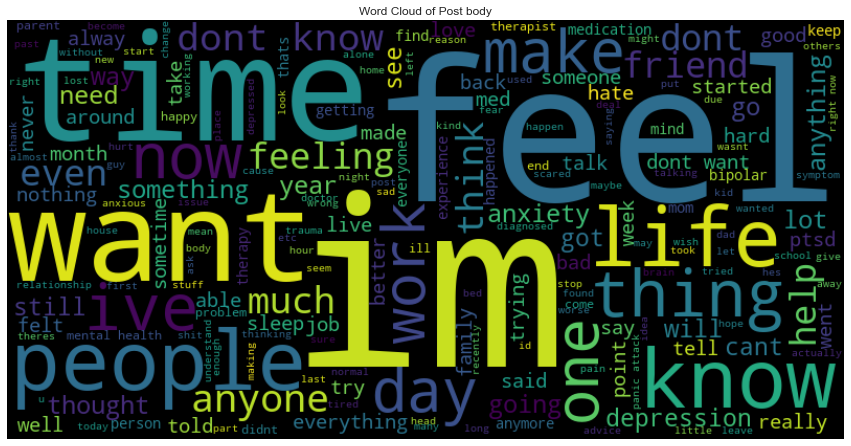

In [8]:
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df['combined_input']))

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Post body')
plt.show()

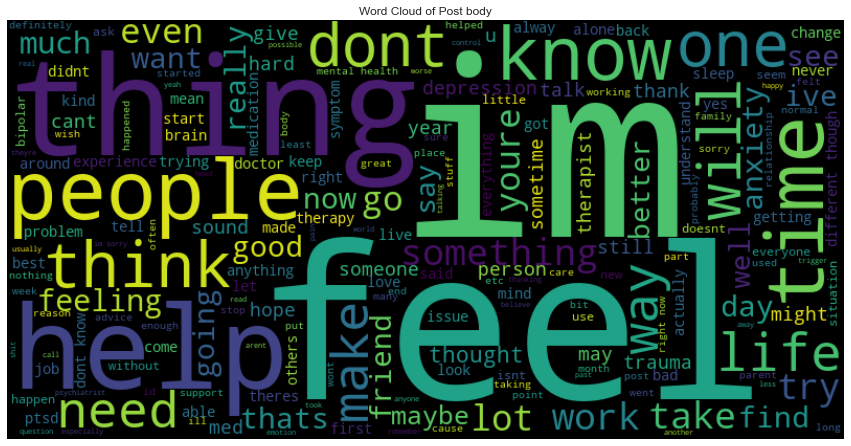

In [9]:
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df['Comment']))

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Post body')
plt.show()

In [10]:
print('input vocab: ', vocab(" ".join(df['combined_input'])))
print('output vocab: ', vocab(" ".join(df['Comment'])))

input vocab:  [' ', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
output vocab:  [' ', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


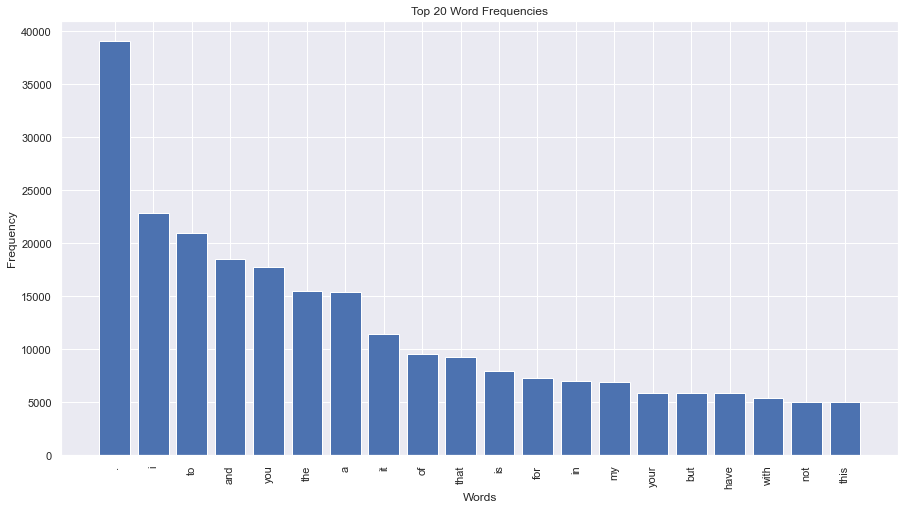

In [11]:
all_text = ' '.join(df['Comment'])

# Calculate word frequencies
word_counts = Counter(all_text.split())

# Get the top 20 words and their frequencies
top_words = word_counts.most_common(20)
top_words = dict(top_words)

# Plot the bar graph
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequencies')
plt.xticks(rotation=90)
plt.show()

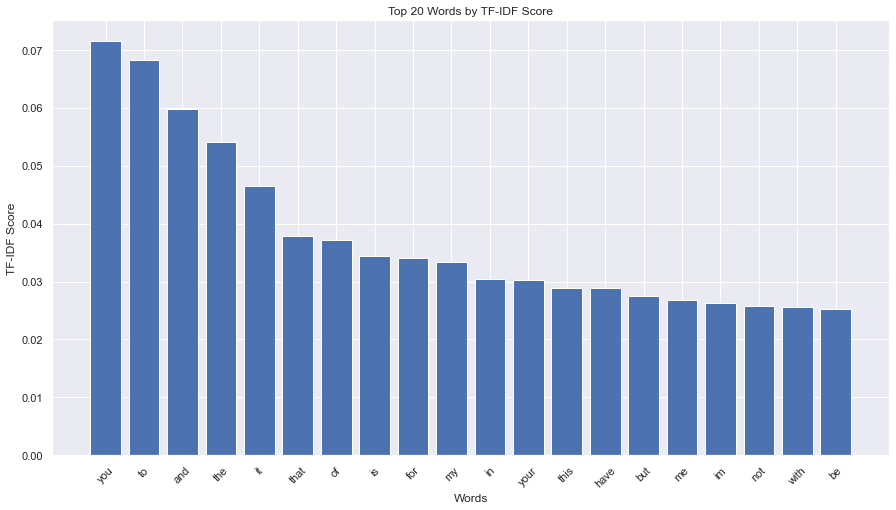

In [12]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Comment'])

# Get the list of feature terms (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calculate the TF-IDF scores for each term
tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]

# Create a dictionary to store the TF-IDF scores for each term
term_scores = dict(zip(feature_names, tfidf_scores))

# Get the top 20 words based on TF-IDF scores
top_words = dict(sorted(term_scores.items(), key=lambda x: x[1], reverse=True)[:20])

# Plot the bar graph
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title('Top 20 Words by TF-IDF Score')
plt.xticks(rotation=45)
plt.show()

Cluster 1:
32                  thank you i will have to try this out
50                      thank you i would appreciate that
54                 thank you good point on the idea phase
78           thank you for your response . im looking now
96                                            thank you 3
                              ...                        
9317    i honestly found this very inspiring thank you...
9321                                          thank you .
9383    thank you for this may i ask if it was covered...
9610    thank you i truly thank you for your words and...
9632    thank you that doubt is a snag for my mind som...
Name: Comment, Length: 199, dtype: object



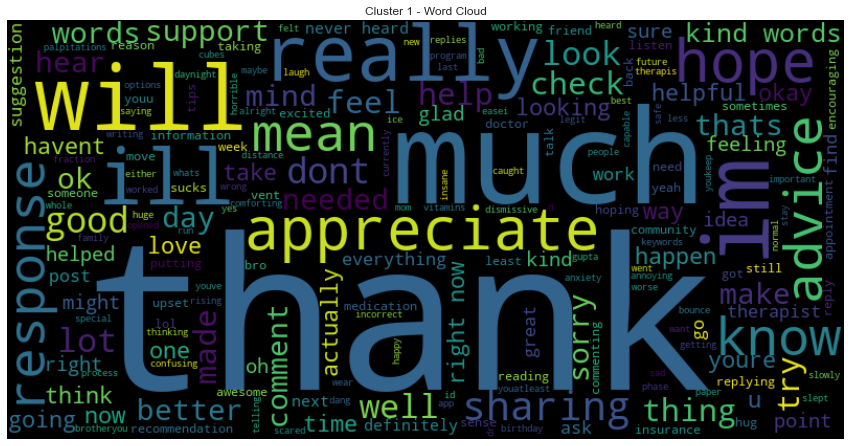

Cluster 2:
2       its rough . im about 2 weeks into fluoxetine a...
4       obviously its okay to think you might have a d...
5       i have had this problem myself but pulled myse...
10      i too have obsession issues and sometimes its ...
11      im the same . the only way i stop saying or do...
                              ...                        
9637    you dont have to say sorry i cant think straig...
9641    comparison is the thief of joy . more importan...
9644    yes . i can relate . when i have an irrational...
9646    brene brown has some really good research on t...
9648    i try to go to bed a little hungry and then al...
Name: Comment, Length: 2781, dtype: object



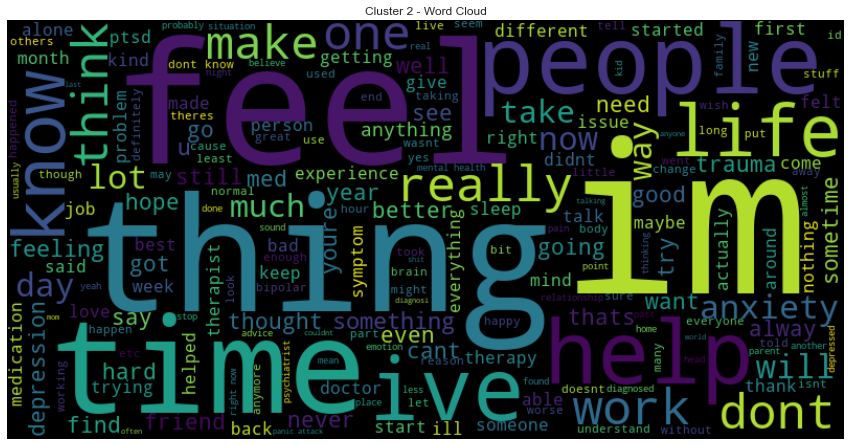

Cluster 3:
6       well it can be hard to be productive and do th...
8       if you dont follow your path and let fear cont...
12      i know that despite everyone hating them this ...
13      see i know what youre talking about like your ...
19      ive always been a people pleaser . what i lear...
                              ...                        
9626    from the way you speak my guess would be that ...
9627    this makes a ton of sense . id been on antidep...
9635    sorry for belated reply i just want to let you...
9642    yes but dont forget that many of those people ...
9645    this is a very very real thing that causes anx...
Name: Comment, Length: 1353, dtype: object



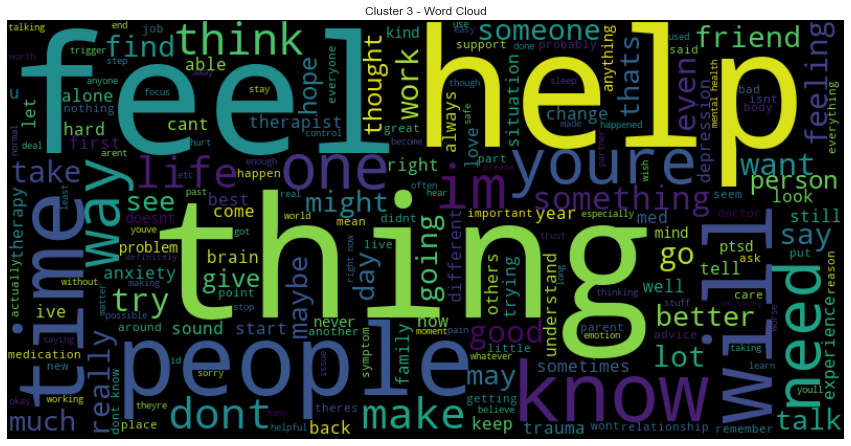

Cluster 4:
0       its not instrumental but the kooks inside inin...
14      hey its gon na be okay the high will pass . dr...
18      the first step is pleasing the most important ...
26                                  travel out of country
27      accomplish a goal that makes you feel proud of...
                              ...                        
9623    i always say i have an underlying melancholy t...
9630    cant stress enough the value of everything thi...
9638                                your shouts are heard
9643    always always only compare yourself to your pr...
9647                    we got this . one day at a time .
Name: Comment, Length: 3138, dtype: object



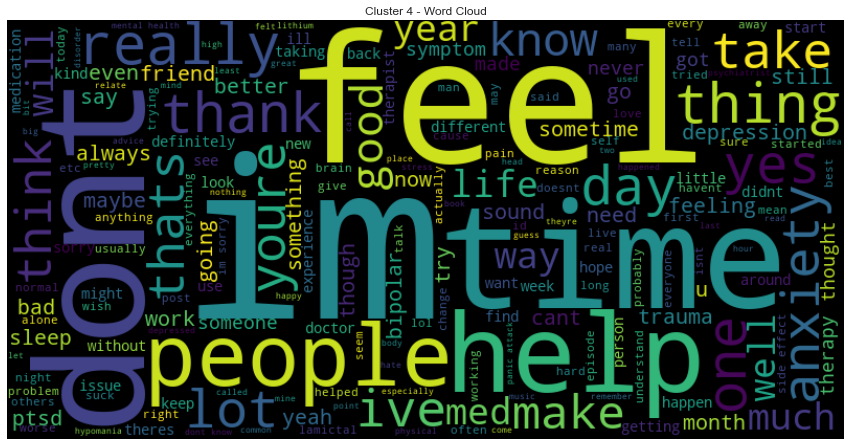

Cluster 5:
7481    it appears you may be asking if you or a loved...
7483    it appears you may be asking if you or a loved...
7489    it appears you may be asking if you or a loved...
7496    it appears you may be asking if you or a loved...
7519    it appears you may be asking if you or a loved...
                              ...                        
8700    it appears you may be asking if you or a loved...
8711    it appears you may be asking if you or a loved...
8725    it appears you may be asking if you or a loved...
8779    it appears you may be asking if you or a loved...
8787    it appears you may be asking if you or a loved...
Name: Comment, Length: 91, dtype: object



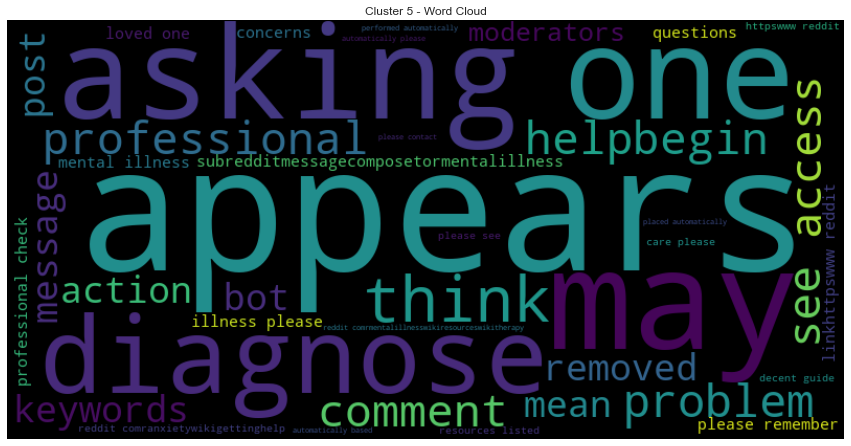

Cluster 6:
1       most likely if youre drinking while taking you...
3       diagnosing yourself is not fine . even doctors...
7       woah you are like the villain arc personified ...
9             at least you know you tried thats important
16      sorry i need to clarify but dont want to trigg...
                              ...                        
9634    i joined meet up when im at my lowest . i made...
9639    isnt that one of the best things about reddit ...
9640    oftentimes other redditors will tell people th...
9649    i feel you i often just sob . someone suggeste...
9650    youre struggling to do anything with your life...
Name: Comment, Length: 2016, dtype: object



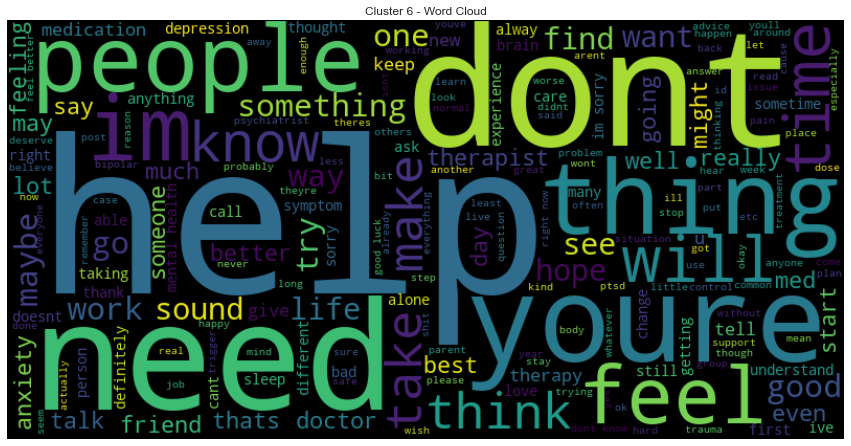

Cluster 7:
245     deleted
471     deleted
830     deleted
895     deleted
897     deleted
         ...   
9535    deleted
9560    deleted
9617    deleted
9622    deleted
9631    deleted
Name: Comment, Length: 73, dtype: object



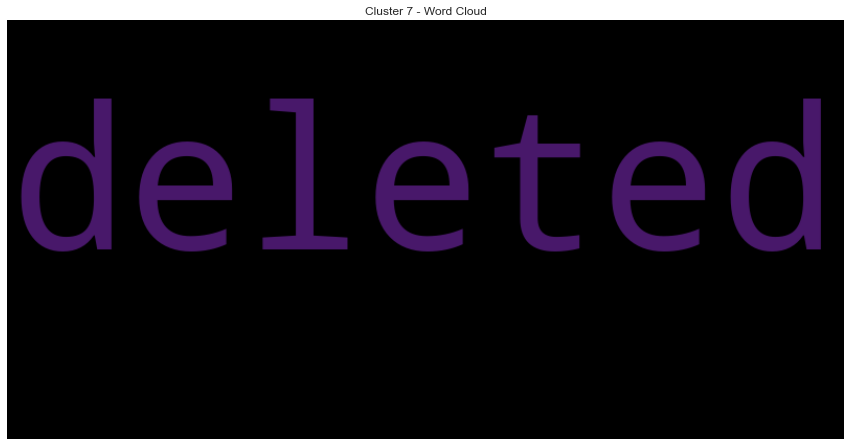

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a list of TF-IDF vectors
tfidf_vectors = tfidf_matrix.toarray()

# Specify the number of clusters
num_clusters = 7

# Perform clustering using K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_vectors)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Assign the cluster labels to your dataframe
df['cluster'] = cluster_labels

# Explore the clusters
for cluster in range(num_clusters):
    cluster_data = df[df['cluster'] == cluster]['Comment']
    print(f"Cluster {cluster+1}:\n{cluster_data}\n")
    
    # Generate word cloud for the cluster
    cluster_text = ' '.join(cluster_data)
    wordcloud = WordCloud(width=800, height=400).generate(cluster_text)
    
    # Plot the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Cluster {cluster+1} - Word Cloud")
    plt.axis('off')
    plt.show()

### We notice that the values in the cluster 7 are all deleted commets. so we will drop that cluster.

In [15]:
df = df[df['cluster'] != 7]
df.to_csv('datasets/reddit_comments_cleaned_nlp.csv', index=False)